<div style="margin-bottom: 32px;">
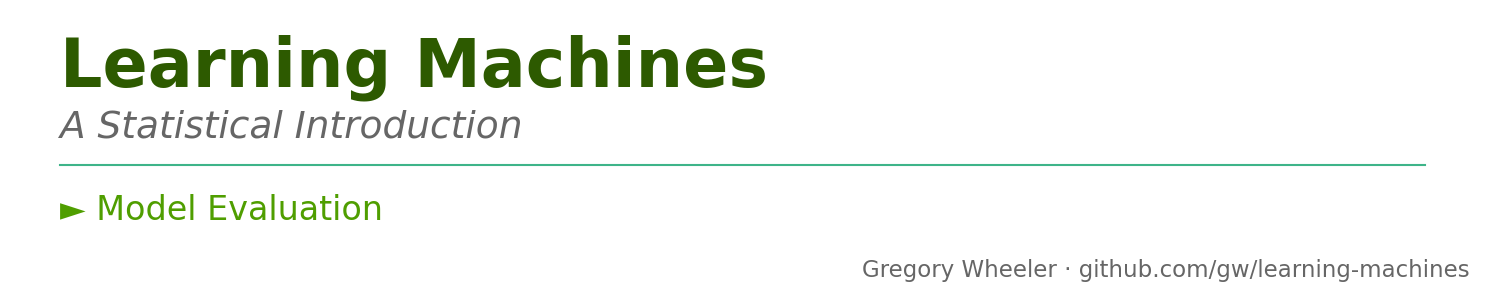
</div>


# Model Evaluation

How do we know if a model will perform well on data it hasn't seen? This notebook makes evaluation concrete: we implement cross-validation from scratch, build confusion matrices, and trace how changing the classification threshold affects precision, recall, and the ROC curve.

**What computation adds**: Formulas for precision and recall are easy to state; watching them change as you slide the decision threshold reveals the tradeoff. Calibration plots show whether predicted probabilities actually mean what they claim.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import sys
from pathlib import Path

# Add the notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt

# Apply the style and set notebook mode (green palette)
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

# For reproducibility
np.random.seed(42)

---
## 1. The Evaluation Problem

**Goal**: Estimate how well our model will perform on *new, unseen data*.

**The trap**: If we evaluate on training data, we get an overly optimistic estimate (especially for complex models that memorize).

Let's create a classification dataset to work with throughout this notebook.

In [2]:
def generate_classification_data(n_samples=500, seed=42):
    """Generate binary classification data with non-linear boundary."""
    np.random.seed(seed)
    
    # Create data with a slightly curved decision boundary
    # Class depends on: x1 + 0.5*x2^2 > threshold
    X = np.random.randn(n_samples, 2) * 1.5
    
    # Non-linear boundary: y=1 if x1 + 0.3*x2^2 > 0.5
    boundary = X[:, 0] + 0.3 * X[:, 1]**2
    y = (boundary > 0.5).astype(int)
    
    # Add label noise (flip 5% of labels)
    noise_idx = np.random.choice(n_samples, size=int(0.05 * n_samples), replace=False)
    y[noise_idx] = 1 - y[noise_idx]
    
    # Shuffle
    idx = np.random.permutation(n_samples)
    return X[idx], y[idx]

X, y = generate_classification_data(500)
print(f"Dataset: {len(y)} samples")
print(f"Class distribution: {(y==0).sum()} negative, {(y==1).sum()} positive ({y.mean():.1%} positive)")

Dataset: 500 samples
Class distribution: 350 negative, 150 positive (30.0% positive)


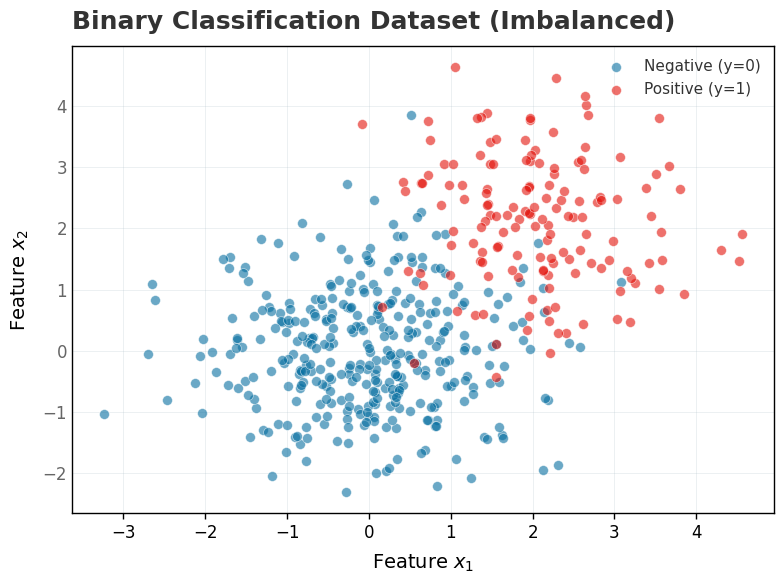

In [3]:
# Visualize
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X[y==0, 0], X[y==0, 1], c=mt.BLUE, s=50, alpha=0.6,
           label='Negative (y=0)', edgecolors='white', linewidths=0.5)
ax.scatter(X[y==1, 0], X[y==1, 1], c=mt.RED, s=50, alpha=0.6,
           label='Positive (y=1)', edgecolors='white', linewidths=0.5)

ax.set_xlabel('Feature $x_1$')
ax.set_ylabel('Feature $x_2$')
ax.set_title('Binary Classification Dataset (Imbalanced)', fontweight='bold', loc='left')
ax.legend()

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 2. Train/Test Split

The simplest evaluation strategy: split data into training and test sets.

In [4]:
def train_test_split(X, y, test_size=0.2, seed=None):
    """Split data into training and test sets."""
    if seed is not None:
        np.random.seed(seed)
    
    n = len(y)
    n_test = int(n * test_size)
    
    idx = np.random.permutation(n)
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=42)

print(f"Training set: {len(y_train)} samples ({y_train.mean():.1%} positive)")
print(f"Test set: {len(y_test)} samples ({y_test.mean():.1%} positive)")

Training set: 400 samples (30.2% positive)
Test set: 100 samples (29.0% positive)


In [5]:
# Train a simple logistic regression classifier
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def train_logistic(X, y, learning_rate=0.1, n_iterations=1000):
    """Train logistic regression with gradient descent."""
    m, n = X.shape
    X_design = np.column_stack([np.ones(m), X])
    theta = np.zeros(n + 1)
    
    for _ in range(n_iterations):
        h = sigmoid(X_design @ theta)
        gradient = (1/m) * X_design.T @ (h - y)
        theta -= learning_rate * gradient
    
    return theta

def predict_proba(X, theta):
    """Return probability of class 1."""
    m = X.shape[0]
    X_design = np.column_stack([np.ones(m), X])
    return sigmoid(X_design @ theta)

def predict(X, theta, threshold=0.5):
    """Return class predictions."""
    return (predict_proba(X, theta) >= threshold).astype(int)

# Train model
theta = train_logistic(X_train, y_train)

# Evaluate
train_acc = np.mean(predict(X_train, theta) == y_train)
test_acc = np.mean(predict(X_test, theta) == y_test)

print(f"Training accuracy: {train_acc:.1%}")
print(f"Test accuracy: {test_acc:.1%}")

Training accuracy: 94.0%
Test accuracy: 97.0%


---
## 3. Cross-Validation

A single train/test split can be noisy. **K-fold cross-validation** gives a more robust estimate:

1. Split data into K equal folds
2. For each fold k:
   - Train on all folds except k
   - Test on fold k
3. Average the K test scores

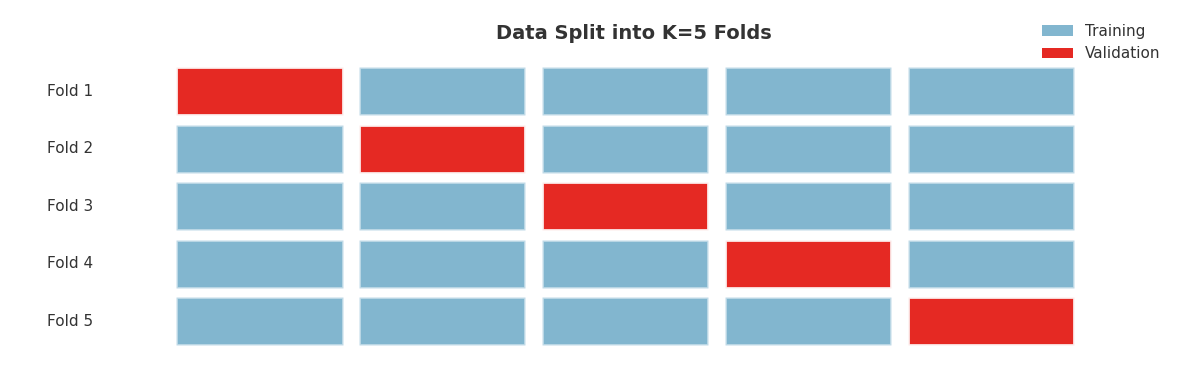

In [6]:
# Visualize K-fold CV
fig, ax = plt.subplots(figsize=(12, 4))

K = 5
colors_train = mt.BLUE
colors_test = mt.RED

for fold in range(K):
    for k in range(K):
        color = colors_test if k == fold else colors_train
        alpha = 0.9 if k == fold else 0.5
        rect = Rectangle((k * 1.1, (K - 1 - fold) * 0.6), 1, 0.5,
                         facecolor=color, alpha=alpha, edgecolor='white', linewidth=2)
        ax.add_patch(rect)
    
    # Add fold label
    ax.text(-0.5, (K - 1 - fold) * 0.6 + 0.25, f'Fold {fold + 1}', 
            va='center', ha='right', fontsize=11)

# Labels
ax.text(2.5 * 1.1, K * 0.6 + 0.2, 'Data Split into K=5 Folds', 
        ha='center', fontsize=14, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_train, alpha=0.5, label='Training'),
                   Patch(facecolor=colors_test, alpha=0.9, label='Validation')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

ax.set_xlim(-1, 6)
ax.set_ylim(-0.3, K * 0.6 + 0.5)
ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
def k_fold_cv(X, y, k=5, seed=42):
    """
    Perform K-fold cross-validation.
    
    Returns list of (train_indices, test_indices) for each fold.
    """
    np.random.seed(seed)
    n = len(y)
    indices = np.random.permutation(n)
    fold_size = n // k
    
    folds = []
    for i in range(k):
        start = i * fold_size
        end = start + fold_size if i < k - 1 else n
        
        test_idx = indices[start:end]
        train_idx = np.concatenate([indices[:start], indices[end:]])
        
        folds.append((train_idx, test_idx))
    
    return folds

def cross_validate(X, y, k=5):
    """Run K-fold CV and return scores."""
    folds = k_fold_cv(X, y, k)
    scores = []
    
    for fold_num, (train_idx, test_idx) in enumerate(folds):
        X_train_cv, y_train_cv = X[train_idx], y[train_idx]
        X_test_cv, y_test_cv = X[test_idx], y[test_idx]
        
        # Train and evaluate
        theta = train_logistic(X_train_cv, y_train_cv)
        acc = np.mean(predict(X_test_cv, theta) == y_test_cv)
        scores.append(acc)
        
        print(f"Fold {fold_num + 1}: accuracy = {acc:.1%}")
    
    return scores

print("5-Fold Cross-Validation:")
print("-" * 30)
cv_scores = cross_validate(X, y, k=5)
print("-" * 30)
print(f"Mean: {np.mean(cv_scores):.1%} (+/- {np.std(cv_scores):.1%})")

5-Fold Cross-Validation:
------------------------------
Fold 1: accuracy = 97.0%
Fold 2: accuracy = 97.0%
Fold 3: accuracy = 94.0%
Fold 4: accuracy = 94.0%
Fold 5: accuracy = 91.0%
------------------------------
Mean: 94.6% (+/- 2.2%)


---
## 4. The Confusion Matrix

Accuracy alone doesn't tell the whole story, especially with imbalanced classes. The **confusion matrix** breaks down predictions:

|  | Predicted Negative | Predicted Positive |
|--|-------------------|-------------------|
| **Actual Negative** | True Negative (TN) | False Positive (FP) |
| **Actual Positive** | False Negative (FN) | True Positive (TP) |

In [8]:
def confusion_matrix(y_true, y_pred):
    """Compute confusion matrix."""
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    return np.array([[TN, FP], [FN, TP]])

def plot_confusion_matrix(cm, ax=None):
    """Plot confusion matrix as heatmap."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    im = ax.imshow(cm, cmap='Blues')
    
    # Labels
    labels = ['Negative', 'Positive']
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    
    # Add text annotations
    thresh = cm.max() / 2
    cell_labels = [['TN', 'FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            color = 'white' if cm[i, j] > thresh else 'black'
            ax.text(j, i, f'{cell_labels[i][j]}\n{cm[i, j]}',
                   ha='center', va='center', color=color, fontsize=14, fontweight='bold')
    
    ax.set_title('Confusion Matrix', fontweight='bold')
    
    return ax

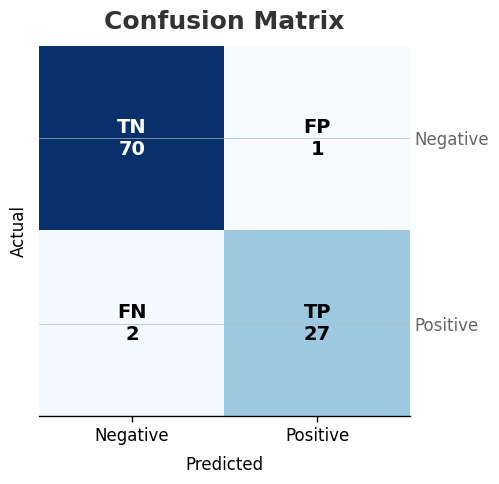


Confusion Matrix Breakdown:
  True Negatives (TN): 70
  False Positives (FP): 1
  False Negatives (FN): 2
  True Positives (TP): 27


In [9]:
# Compute predictions on test set
y_pred = predict(X_test, theta)
y_proba = predict_proba(X_test, theta)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_matrix(cm, ax)
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN): {cm[0,0]}")
print(f"  False Positives (FP): {cm[0,1]}")
print(f"  False Negatives (FN): {cm[1,0]}")
print(f"  True Positives (TP): {cm[1,1]}")

---
## 5. Precision, Recall, and F1 Score

From the confusion matrix, we derive several important metrics:

**Precision**: Of all predicted positives, how many are actually positive?
$$\text{Precision} = \frac{TP}{TP + FP}$$

**Recall (Sensitivity)**: Of all actual positives, how many did we catch?
$$\text{Recall} = \frac{TP}{TP + FN}$$

**F1 Score**: Harmonic mean of precision and recall
$$F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [10]:
def compute_metrics(y_true, y_pred):
    """Compute classification metrics from predictions."""
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity
    }

metrics = compute_metrics(y_test, y_pred)

print("Classification Metrics:")
print("-" * 30)
for name, value in metrics.items():
    print(f"{name.capitalize():>12}: {value:.3f}")

Classification Metrics:
------------------------------
    Accuracy: 0.970
   Precision: 0.964
      Recall: 0.931
          F1: 0.947
 Specificity: 0.986


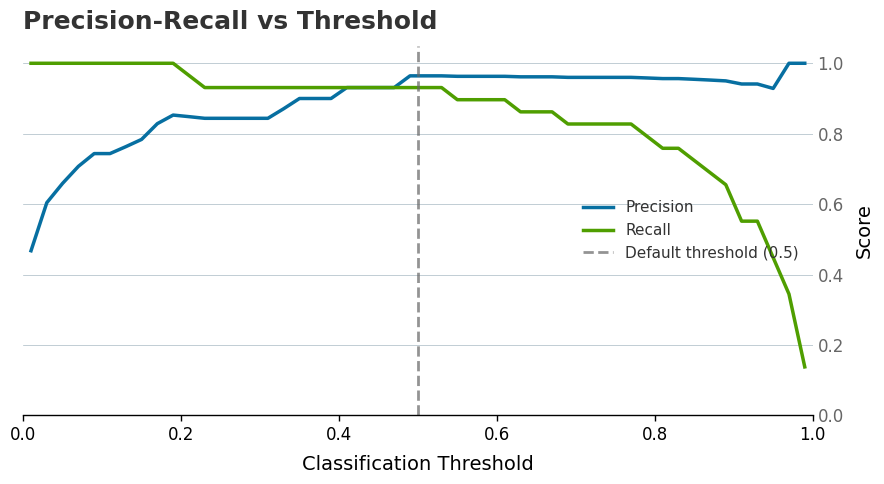

In [11]:
# Visualize precision-recall tradeoff
fig, ax = plt.subplots(figsize=(9, 5))

thresholds = np.linspace(0.01, 0.99, 50)
precisions = []
recalls = []

for thresh in thresholds:
    y_pred_t = (y_proba >= thresh).astype(int)
    m = compute_metrics(y_test, y_pred_t)
    precisions.append(m['precision'])
    recalls.append(m['recall'])

ax.plot(thresholds, precisions, c=mt.BLUE, linewidth=2.5, label='Precision')
ax.plot(thresholds, recalls, c=mt.GREEN, linewidth=2.5, label='Recall')

# Mark default threshold
ax.axvline(x=0.5, color=mt.GRAY, linestyle='--', alpha=0.7, label='Default threshold (0.5)')

ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision-Recall vs Threshold', fontweight='bold', loc='left')
ax.legend(loc='center right')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

**The tradeoff:**
- **Higher threshold** → Fewer positive predictions → Higher precision, lower recall
- **Lower threshold** → More positive predictions → Lower precision, higher recall

The right threshold depends on the cost of false positives vs false negatives in your application.

---
## 6. ROC Curve and AUC

The **ROC curve** (Receiver Operating Characteristic) plots:
- **True Positive Rate (TPR)** = Recall = TP / (TP + FN)
- **False Positive Rate (FPR)** = FP / (FP + TN)

across all possible thresholds.

**AUC** (Area Under the Curve) summarizes the ROC curve:
- AUC = 1.0: Perfect classifier
- AUC = 0.5: Random guessing
- AUC < 0.5: Worse than random (predictions are inverted)

In [12]:
def compute_roc_curve(y_true, y_proba):
    """Compute ROC curve points."""
    thresholds = np.linspace(0, 1, 100)
    tpr_list = []
    fpr_list = []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    return np.array(fpr_list), np.array(tpr_list), thresholds

def compute_auc(fpr, tpr):
    """Compute AUC using trapezoidal rule."""
    # Sort by FPR
    order = np.argsort(fpr)
    fpr_sorted = fpr[order]
    tpr_sorted = tpr[order]
    
    # NumPy 2.0+ uses trapezoid, older versions use trapz
    if hasattr(np, 'trapezoid'):
        return np.trapezoid(tpr_sorted, fpr_sorted)
    else:
        return np.trapz(tpr_sorted, fpr_sorted)

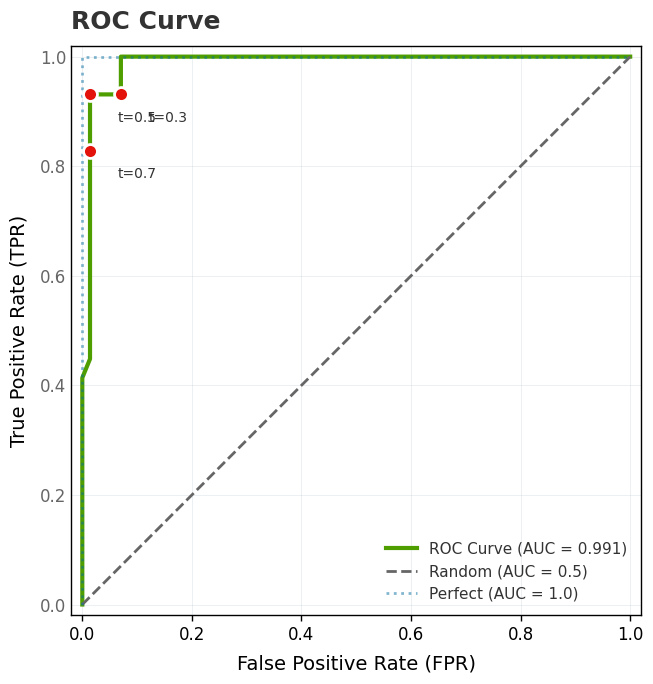

AUC: 0.991


In [13]:
# Compute ROC curve
fpr, tpr, thresholds = compute_roc_curve(y_test, y_proba)
auc = compute_auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 7))

# ROC curve
ax.plot(fpr, tpr, c=mt.GREEN, linewidth=3, label=f'ROC Curve (AUC = {auc:.3f})')

# Random classifier baseline
ax.plot([0, 1], [0, 1], c=mt.GRAY, linestyle='--', linewidth=2, label='Random (AUC = 0.5)')

# Perfect classifier
ax.plot([0, 0, 1], [0, 1, 1], c=mt.BLUE, linestyle=':', linewidth=2, alpha=0.5, label='Perfect (AUC = 1.0)')

# Mark a few threshold points
for thresh in [0.3, 0.5, 0.7]:
    idx = np.argmin(np.abs(thresholds - thresh))
    ax.scatter(fpr[idx], tpr[idx], s=100, zorder=5, c=mt.RED, edgecolors='white', linewidths=2)
    ax.annotate(f't={thresh}', xy=(fpr[idx], tpr[idx]), 
                xytext=(fpr[idx] + 0.05, tpr[idx] - 0.05), fontsize=10)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('ROC Curve', fontweight='bold', loc='left')
ax.legend(loc='lower right')
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.set_aspect('equal')

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"AUC: {auc:.3f}")

**Interpreting the ROC curve:**
- Points in the **upper left** are better (high TPR, low FPR)
- The **diagonal** represents random guessing
- **AUC** gives the probability that a random positive is ranked higher than a random negative

---
## 7. Precision-Recall Curve

For **imbalanced datasets**, the precision-recall curve can be more informative than ROC.

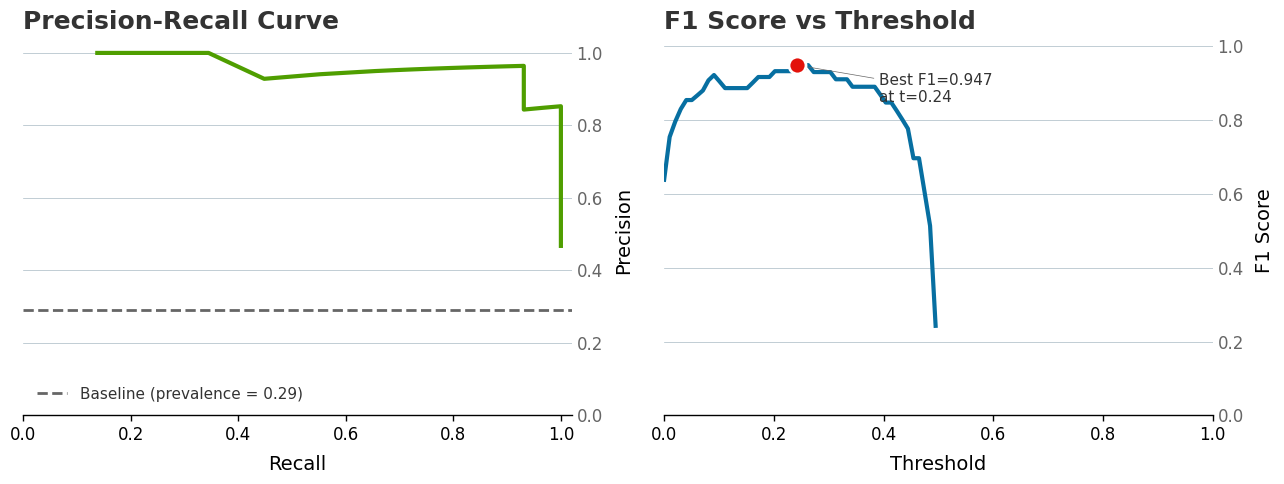

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Precision-Recall curve
ax = axes[0]
ax.plot(recalls, precisions, c=mt.GREEN, linewidth=3)
ax.axhline(y=y_test.mean(), color=mt.GRAY, linestyle='--', 
           label=f'Baseline (prevalence = {y_test.mean():.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve', fontweight='bold', loc='left')
ax.legend(loc='lower left')
ax.set_xlim(0, 1.02)
ax.set_ylim(0, 1.02)
mt.apply_economist_style(ax)

# F1 score vs threshold
ax = axes[1]
f1_scores = [2 * p * r / (p + r) if (p + r) > 0 else 0 
             for p, r in zip(precisions, recalls)]

ax.plot(thresholds[:len(f1_scores)], f1_scores, c=mt.BLUE, linewidth=3)

# Mark maximum
best_idx = np.argmax(f1_scores)
ax.scatter(thresholds[best_idx], f1_scores[best_idx], s=150, c=mt.RED, 
           zorder=5, edgecolors='white', linewidths=2)
ax.annotate(f'Best F1={f1_scores[best_idx]:.3f}\nat t={thresholds[best_idx]:.2f}',
            xy=(thresholds[best_idx], f1_scores[best_idx]),
            xytext=(thresholds[best_idx] + 0.15, f1_scores[best_idx] - 0.1),
            fontsize=11, arrowprops=dict(arrowstyle='->', color=mt.GRAY))

ax.set_xlabel('Threshold')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score vs Threshold', fontweight='bold', loc='left')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

---
## 8. Calibration

A classifier is **well-calibrated** if its predicted probabilities match empirical frequencies:
- When the model says "70% chance of positive", it should be correct ~70% of the time

We visualize this with a **calibration curve** (reliability diagram).

In [15]:
def calibration_curve(y_true, y_proba, n_bins=10):
    """Compute calibration curve."""
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    true_proportions = []
    mean_predicted = []
    bin_counts = []
    
    for i in range(n_bins):
        mask = (y_proba >= bin_edges[i]) & (y_proba < bin_edges[i + 1])
        if mask.sum() > 0:
            true_proportions.append(y_true[mask].mean())
            mean_predicted.append(y_proba[mask].mean())
            bin_counts.append(mask.sum())
        else:
            true_proportions.append(np.nan)
            mean_predicted.append(bin_centers[i])
            bin_counts.append(0)
    
    return np.array(mean_predicted), np.array(true_proportions), np.array(bin_counts)

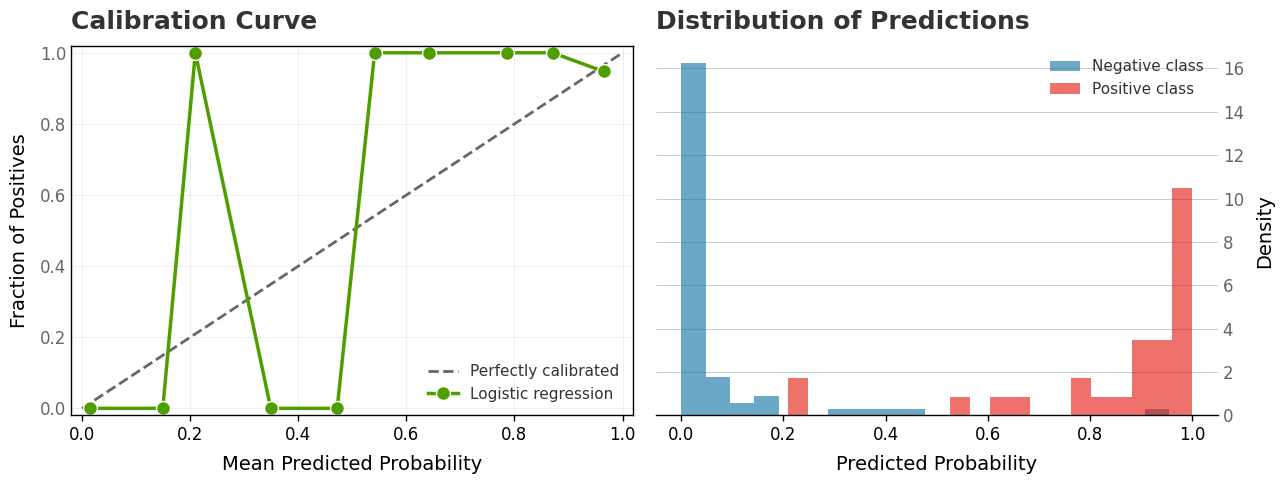

In [16]:
pred_prob, true_prob, counts = calibration_curve(y_test, y_proba, n_bins=10)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Calibration curve
ax = axes[0]
ax.plot([0, 1], [0, 1], c=mt.GRAY, linestyle='--', linewidth=2, label='Perfectly calibrated')

# Filter out NaN values for plotting
mask = ~np.isnan(true_prob)
ax.plot(pred_prob[mask], true_prob[mask], 'o-', c=mt.GREEN, linewidth=2.5, 
        markersize=10, label='Logistic regression')

ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title('Calibration Curve', fontweight='bold', loc='left')
ax.legend(loc='lower right')
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.grid(True, alpha=0.3)

# Histogram of predictions
ax = axes[1]
ax.hist(y_proba[y_test == 0], bins=20, alpha=0.6, color=mt.BLUE, 
        label='Negative class', density=True)
ax.hist(y_proba[y_test == 1], bins=20, alpha=0.6, color=mt.RED,
        label='Positive class', density=True)

ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Density')
ax.set_title('Distribution of Predictions', fontweight='bold', loc='left')
ax.legend()

mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Reading the calibration curve:**
- Points **above the diagonal**: Model is underconfident (predicts lower probabilities than warranted)
- Points **below the diagonal**: Model is overconfident (predicts higher probabilities than warranted)
- **On the diagonal**: Well-calibrated

Logistic regression is typically well-calibrated by construction.

---
## 9. Putting It All Together: Model Comparison

Let's compare models of different complexity using proper evaluation.

In [17]:
def train_polynomial_logistic(X, y, degree, learning_rate=0.1, n_iterations=2000):
    """Train logistic regression with polynomial features."""
    # Create polynomial features
    X_poly = X.copy()
    if degree >= 2:
        X_poly = np.column_stack([X_poly, X[:, 0]**2, X[:, 1]**2, X[:, 0] * X[:, 1]])
    if degree >= 3:
        X_poly = np.column_stack([X_poly, X[:, 0]**3, X[:, 1]**3, 
                                  X[:, 0]**2 * X[:, 1], X[:, 0] * X[:, 1]**2])
    
    # Standardize
    mean = X_poly.mean(axis=0)
    std = X_poly.std(axis=0) + 1e-10
    X_poly = (X_poly - mean) / std
    
    theta = train_logistic(X_poly, y, learning_rate, n_iterations)
    
    return theta, mean, std, degree

def predict_proba_poly(X, model):
    """Predict probabilities with polynomial logistic regression."""
    theta, mean, std, degree = model
    
    X_poly = X.copy()
    if degree >= 2:
        X_poly = np.column_stack([X_poly, X[:, 0]**2, X[:, 1]**2, X[:, 0] * X[:, 1]])
    if degree >= 3:
        X_poly = np.column_stack([X_poly, X[:, 0]**3, X[:, 1]**3,
                                  X[:, 0]**2 * X[:, 1], X[:, 0] * X[:, 1]**2])
    
    X_poly = (X_poly - mean) / std
    return predict_proba(X_poly, theta)

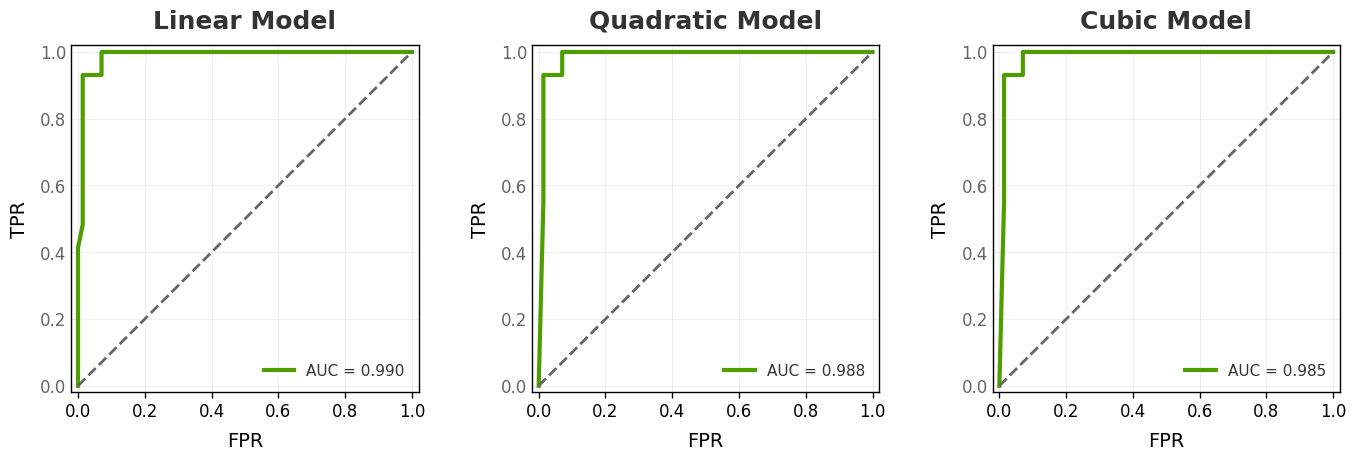

In [18]:
# Compare linear vs polynomial models
models = {
    'Linear': train_polynomial_logistic(X_train, y_train, degree=1),
    'Quadratic': train_polynomial_logistic(X_train, y_train, degree=2),
    'Cubic': train_polynomial_logistic(X_train, y_train, degree=3)
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

for ax, (name, model) in zip(axes, models.items()):
    y_proba_model = predict_proba_poly(X_test, model)
    fpr, tpr, _ = compute_roc_curve(y_test, y_proba_model)
    auc = compute_auc(fpr, tpr)
    
    ax.plot(fpr, tpr, c=mt.GREEN, linewidth=3, label=f'AUC = {auc:.3f}')
    ax.plot([0, 1], [0, 1], c=mt.GRAY, linestyle='--', linewidth=2)
    
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(f'{name} Model', fontweight='bold')
    ax.legend(loc='lower right')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    ax.yaxis.tick_left()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Summary

**Evaluation strategies:**
- **Train/test split**: Simple, but high variance
- **K-fold cross-validation**: More robust estimate

**Classification metrics:**

| Metric | Formula | When to use |
|--------|---------|-------------|
| Accuracy | (TP+TN)/(TP+TN+FP+FN) | Balanced classes |
| Precision | TP/(TP+FP) | Cost of FP is high |
| Recall | TP/(TP+FN) | Cost of FN is high |
| F1 | 2·P·R/(P+R) | Balance precision/recall |
| AUC | Area under ROC | Overall ranking ability |

**Key insights:**
- Accuracy alone is misleading for imbalanced classes
- ROC curves show the tradeoff across all thresholds
- Calibration tells you if probabilities are trustworthy
- Choose metrics based on the costs in your application

**Next steps** (covered in the book):
- Regularization to prevent overfitting
- Using validation sets for hyperparameter tuning